In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pyro
import pyro.distributions as dist

from rethinking import HPDI, MAP, PI, dens, precis

plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["lines.linewidth"] = 1
pyro.enable_validation()
pyro.set_rng_seed(0)

#### Code 4.1

In [2]:
pos = torch.empty(1000, 16).uniform_(-1, 1).sum(1)

#### Code 4.2

In [3]:
(1 + torch.empty(12).uniform_(0, 0.1)).prod()

tensor(1.8004)

#### Code 4.3

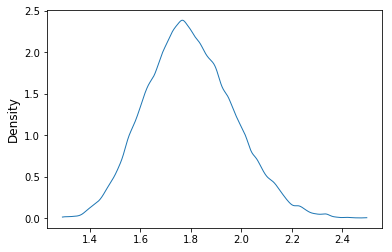

In [4]:
growth = (1 + torch.empty(10000, 12).uniform_(0, 0.1)).prod(1)
dens(growth)

#### Code 4.4

In [5]:
big = (1 + torch.empty(10000, 12).uniform_(0, 0.5)).prod(1)
small = (1 + torch.empty(10000, 12).uniform_(0, 0.01)).prod(1)

#### Code 4.5

In [6]:
log_big = (1 + torch.empty(10000, 12).uniform_(0, 0.5)).prod(1).log()

#### Code 4.6

In [7]:
w, n = 6., 9
p_grid = torch.linspace(start=0, end=1, steps=1000)
posterior = (dist.Binomial(n, p_grid).log_prob(torch.tensor(w)).exp()
             * dist.Uniform(0, 1).log_prob(p_grid).exp())
posterior = posterior / posterior.sum()

#### Code 4.7

In [8]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1

#### Code 4.8

In [9]:
print(d.info())
print(d.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB
None
    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0


#### Code 4.9

In [10]:
d["height"].head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

#### Code 4.10

In [11]:
d2 = d[d["age"] >= 18]
d2_height = torch.tensor(d2["height"].values, dtype=torch.float)

#### Code 4.11

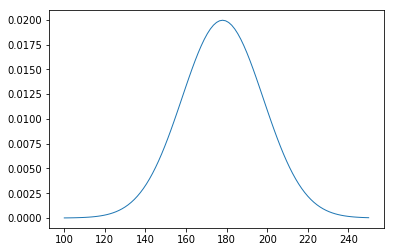

In [12]:
x = torch.linspace(100, 250, 101)
plt.plot(x.tolist(), dist.Normal(178, 20).log_prob(x).exp().tolist());

#### Code 4.12

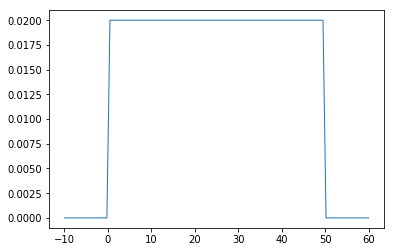

In [13]:
x = torch.linspace(-10, 60, 101)
plt.plot(x.tolist(), dist.Uniform(0, 50, validate_args=False).log_prob(x).exp().tolist());

#### Code 4.13

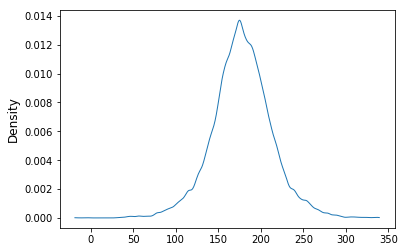

In [14]:
sample_mu = torch.empty(int(1e4)).normal_(178, 20)
sample_sigma = torch.empty(int(1e4)).uniform_(0, 50)
prior_h = dist.Normal(sample_mu, sample_sigma).sample()
dens(prior_h)

#### Code 4.14

In [15]:
mu_list = torch.linspace(start=140, end=160, steps=200)
sigma_list = torch.linspace(start=4, end=9, steps=200)
post = {"mu": mu_list.expand(200, 200).reshape(-1),
        "sigma": sigma_list.expand(200, 200).t().reshape(-1)}
post_LL = dist.Normal(post["mu"], post["sigma"]).log_prob(d2_height.unsqueeze(1)).sum(0)
post_prod = (post_LL + dist.Normal(178, 20).log_prob(post["mu"])
             + dist.Uniform(0, 50).log_prob(post["sigma"]))
post_prob = (post_prod - max(post_prod)).exp()

#### Code 4.15

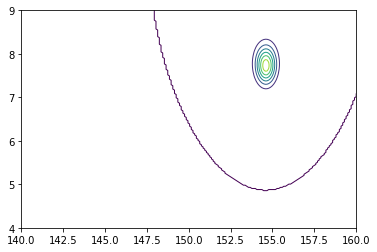

In [16]:
plt.contour(post["mu"].reshape(200, 200).tolist(),
            post["sigma"].reshape(200, 200).tolist(),
            post_prob.reshape(200, 200).tolist());

#### Code 4.16

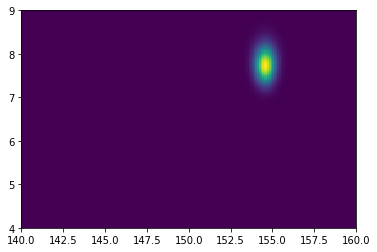

In [17]:
plt.imshow(post_prob.reshape(200, 200).tolist(), aspect="auto",
           origin="lower", extent=(140, 160, 4, 9));

#### Code 4.17

In [18]:
sample_rows = torch.multinomial(input=post_prob, num_samples=int(1e4), replacement=True)
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

#### Code 4.18

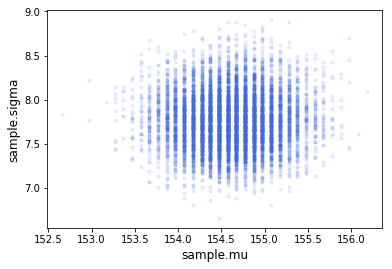

In [19]:
plt.plot(sample_mu.tolist(), sample_sigma.tolist(), "o",
         markersize=3, c="royalblue", alpha=0.1)
plt.xlabel("sample.mu")
plt.ylabel("sample.sigma");

#### Code 4.19

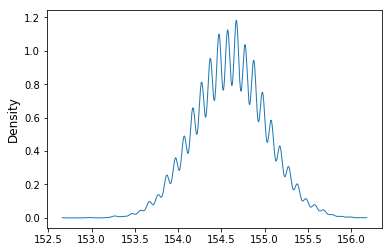

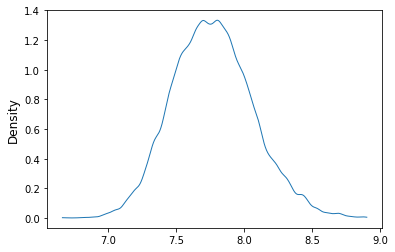

In [20]:
dens(sample_mu)
plt.show()
dens(sample_sigma)

#### Code 4.20

In [21]:
print(HPDI(sample_mu))
print(HPDI(sample_sigma))

tensor([153.8694, 155.1759])
tensor([7.3166, 8.2462])


#### Code 4.21

In [22]:
d3 = d2_height[torch.multinomial(torch.ones(d2_height.shape), num_samples=20)]

#### Code 4.22

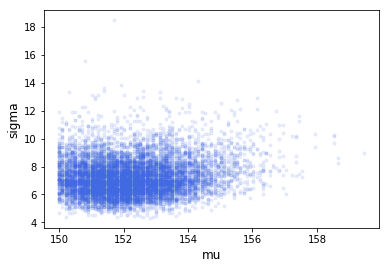

In [23]:
mu_list = torch.linspace(start=150, end=170, steps=200)
sigma_list = torch.linspace(start=4, end=20, steps=200)
post2 = {"mu": mu_list.expand(200, 200).reshape(-1),
         "sigma": sigma_list.expand(200, 200).t().reshape(-1)}
post2_LL = dist.Normal(post2["mu"], post2["sigma"]).log_prob(d3.unsqueeze(1)).sum(0)
post2_prod = (post2_LL + dist.Normal(178, 20).log_prob(post2["mu"])
              + dist.Uniform(0, 50).log_prob(post2["sigma"]))
post2_prob = (post2_prod - max(post2_prod)).exp()
sample2_rows = torch.multinomial(input=post2_prob, num_samples=int(1e4), replacement=True)
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.plot(sample2_mu.tolist(), sample2_sigma.tolist(), "o",
         markersize=3, c="royalblue", alpha=0.1)
plt.xlabel("mu")
plt.ylabel("sigma");

#### Code 4.23

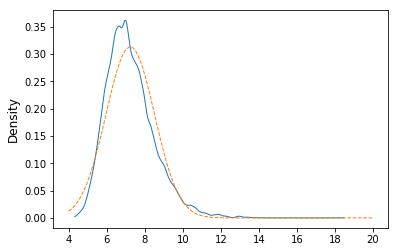

In [24]:
dens(sample2_sigma)
x = torch.linspace(4, 20, 101)
plt.plot(x.tolist(), dist.Normal(sample2_sigma.mean(),
    sample2_sigma.std()).log_prob(x).exp().tolist(), "--");

#### Code 4.24

In [25]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d2 = d[d["age"] >= 18]
d2_height = torch.tensor(d2["height"].values, dtype=torch.float)

#### Code 4.25

In [26]:
def flist(height):
    mu = pyro.sample("mu", dist.Normal(178, 20))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

#### Code 4.26

In [27]:
m4_1 = MAP("m4.1", flist, height=d2_height)
m4_1.fit();

#### Code 4.27

In [28]:
m4_1.precis()

,Mean,StdDev,5.5%,94.5%
mu,154.61,0.41,153.95,155.27
sigma,7.73,0.29,7.27,8.20


#### Code 4.28

In [29]:
start = {"mu": d2_height.mean(), "sigma": d2_height.std()}

#### Code 4.29

In [30]:
def m4_2_model(height):
    mu = pyro.sample("mu", dist.Normal(178, 0.1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_2 = MAP("m4.2", m4_2_model, height=d2_height)
m4_2.fit()
m4_2.precis()

,Mean,StdDev,5.5%,94.5%
mu,177.86,0.10,177.70,178.02
sigma,24.52,0.93,23.03,26.00


#### Code 4.30

In [31]:
m4_1.vcov()

tensor([[0.1697, 0.0002],
        [0.0002, 0.0849]])

#### Code 4.31

In [32]:
print(m4_1.vcov().diag())
cov = m4_1.vcov()
print(cov / cov.diag().ger(cov.diag()).sqrt())

tensor([0.1697, 0.0849])
tensor([[1.0000, 0.0018],
        [0.0018, 1.0000]])


#### Code 4.32

In [33]:
post = m4_1.extract_samples(n=int(1e4))
{latent: post[latent][:5] for latent in post}

{'mu': tensor([154.2038, 154.9543, 154.6063, 154.3695, 155.0358]),
 'sigma': tensor([7.5667, 7.8179, 7.7822, 7.8237, 7.5597])}

#### Code 4.33

In [34]:
precis(post)

,Mean,StdDev,|0.89,0.89|
mu,154.61,0.41,153.96,155.25
sigma,7.73,0.29,7.26,8.19


#### Code 4.34

In [35]:
post = dist.MultivariateNormal(loc=torch.stack(list(m4_1.coef().values())),
    covariance_matrix=m4_1.vcov()).sample(torch.Size([int(1e4)]))

#### Code 4.35

In [36]:
def m4_1_logsigma_model(height):
    mu = pyro.sample("mu", dist.Normal(178, 20))
    log_sigma = pyro.sample("log_sigma", dist.Normal(2, 10))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, log_sigma.exp()), obs=height)

m4_1_logsigma = MAP("m4.1_logsigma", m4_1_logsigma_model, height=d2_height)
m4_1_logsigma.fit();

#### Code 4.36

In [37]:
post = m4_1_logsigma.extract_samples()
sigma = post["log_sigma"].exp()

#### Code 4.37

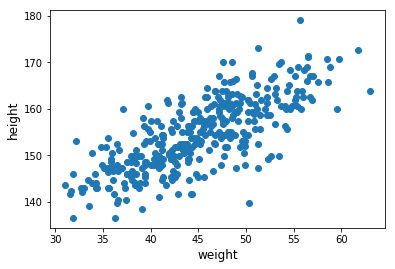

In [38]:
plt.plot(d2["weight"], d2["height"], "o")
plt.xlabel("weight")
plt.ylabel("height");

#### Code 4.38

In [39]:
# load data again, since it's a long way back
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d2 = d[d["age"] >= 18]
d2_weight = torch.tensor(d2["weight"].values, dtype=torch.float)
d2_height = torch.tensor(d2["height"].values, dtype=torch.float)

# fit model
def m4_3_model(weight, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    b = pyro.sample("b", dist.Normal(0, 10))
    mu = a + b * weight
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_3 = MAP("m4.3", m4_3_model, weight=d2_weight, height=d2_height)
m4_3.fit(lr=0.2);

#### Code 4.39

In [40]:
def m4_3b_model(weight, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    b = pyro.sample("b", dist.Normal(0, 10))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(a + b * weight, sigma), obs=height)

m4_3b = MAP("m4.3b", m4_3b_model, weight=d2_weight, height=d2_height)
m4_3b.fit(lr=0.2);

#### Code 4.40

In [41]:
m4_3.precis()

,Mean,StdDev,5.5%,94.5%
a,113.91,1.91,110.86,116.95
b,0.90,0.04,0.84,0.97
sigma,5.07,0.19,4.77,5.38


#### Code 4.41

In [42]:
m4_3.precis(corr=True)

,Mean,StdDev,5.5%,94.5%,a,b,sigma
a,113.91,1.91,110.86,116.95,1.00,-0.99,0.0
b,0.90,0.04,0.84,0.97,-0.99,1.00,-0.0
sigma,5.07,0.19,4.77,5.38,0.00,-0.00,1.0


#### Code 4.42

In [43]:
d2_weight_c = d2_weight - d2_weight.mean()

#### Code 4.43

In [44]:
m4_4 = MAP("m4.4", m4_3_model, weight=d2_weight_c, height=d2_height)
m4_4.fit(lr=0.2);

#### Code 4.44

In [45]:
m4_4.precis(corr=True)

,Mean,StdDev,5.5%,94.5%,a,b,sigma
a,154.60,0.27,154.17,155.03,1.0,0.0,0.0
b,0.91,0.04,0.84,0.97,0.0,1.0,0.0
sigma,5.07,0.19,4.77,5.38,0.0,0.0,1.0


#### Code 4.45

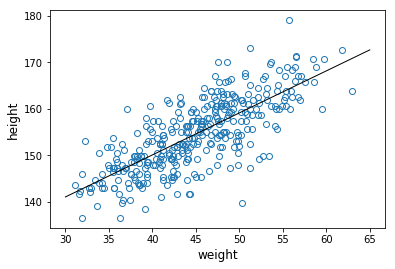

In [46]:
plt.plot("weight", "height", "o", data=d2, fillstyle="none")
plt.xlabel("weight")
plt.ylabel("height")
x = torch.linspace(30, 65, 101)
plt.plot(x.tolist(), (m4_3.coef()["a"] + m4_3.coef()["b"] * x).tolist(), "k");

#### Code 4.46

In [47]:
post = m4_3.extract_samples()

#### Code 4.47

In [48]:
{latent: post[latent][:5] for latent in post}

{'a': tensor([111.2050, 113.0446, 112.6694, 114.2916, 113.4258]),
 'b': tensor([0.9660, 0.9185, 0.9354, 0.8956, 0.9156]),
 'sigma': tensor([4.7394, 5.3187, 5.0055, 5.0319, 4.8241])}

#### Code 4.48

In [49]:
N = 10
dN = {"weight": d2_weight[:N], "height": d2_height[:N]}
mN = MAP("mN", m4_3_model, **dN)
mN.fit(lr=0.2);

#### Code 4.49

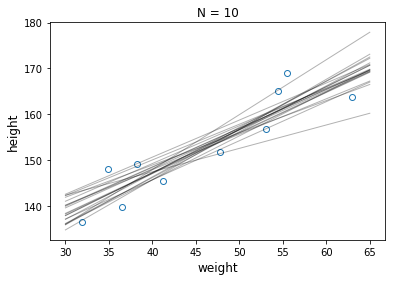

In [50]:
# extract 20 samples from the posterior
post = mN.extract_samples(n=20)

# display raw data and sample size
plt.plot(dN["weight"].tolist(), dN["height"].tolist(), "o", fillstyle="none")
plt.xlabel("weight")
plt.ylabel("height")
plt.title("N = {}".format(N))

# plot the lines, with transparency
x = torch.linspace(30, 65, 101)
for i in range(20):
    plt.plot(x.tolist(), (post["a"][i] + post["b"][i] * x).tolist(), "k", alpha=0.3);

#### Code 4.50

In [51]:
post = m4_3.extract_samples()
mu_at_50 = post["a"] + post["b"] * 50

#### Code 4.51

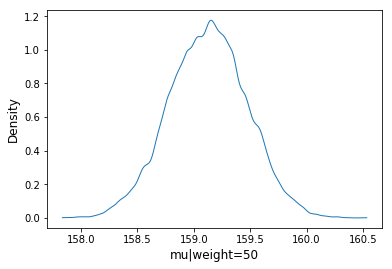

In [52]:
dens(mu_at_50)
plt.xlabel("mu|weight=50");

#### Code 4.52

In [53]:
HPDI(mu_at_50, prob=0.89)

tensor([158.5684, 159.6685])

#### Code 4.53

In [54]:
mu = m4_3.link()
print(mu.shape)
print(mu[:5, 0])

torch.Size([1000, 352])
tensor([157.4892, 156.8936, 157.0411, 157.0714, 157.0306])


#### Code 4.54

In [55]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = torch.arange(start=25., end=71, step=1)

# use link to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = m4_3.link(weight=weight_seq)
mu.shape, mu[:5, 0]

(torch.Size([1000, 46]),
 tensor([136.8063, 135.7936, 137.5506, 135.4134, 136.8770]))

#### Code 4.55

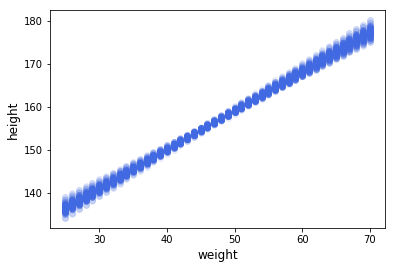

In [56]:
# use visible=False to hide raw data
plt.plot("weight", "height", "o", data=d2, visible=False)
plt.xlabel("weight")
plt.ylabel("height")

# loop over samples and plot each mu value
for i in range(100):
    plt.plot(weight_seq.tolist(), mu[i].tolist(), "o", c="royalblue", alpha=0.1)

#### Code 4.56

In [57]:
# summarize the distribution of mu
mu_mean = mu.mean(0)
mu_HPDI = HPDI(mu, prob=0.89, dim=0)

#### Code 4.57

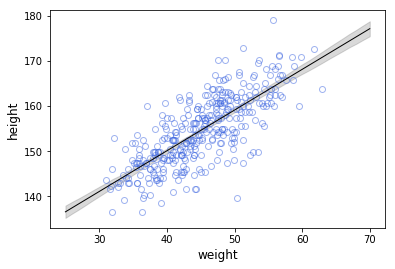

In [58]:
# plot raw data
# fading out points to make line and interval more visible
plt.plot("weight", "height", "o", data=d2, c="royalblue", alpha=0.5, fillstyle="none")
plt.xlabel("weight")
plt.ylabel("height")

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq.tolist(), mu_mean.tolist(), c="k")

# plot a shaded region for 89% HPDI
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.15);

#### Code 4.58

In [59]:
post = m4_3.extract_samples()
mu_link = lambda weight: post["a"].unsqueeze(1) + post["b"].unsqueeze(1) * weight
weight_seq = torch.arange(start=25., end=71, step=1)
mu = mu_link(weight_seq)
mu_mean = mu.mean(0)
mu_HPDI = HPDI(mu, prob=0.89, dim=0)

#### Code 4.59

In [60]:
sim_height = m4_3.sim(weight=weight_seq)
print(sim_height.shape)
print(sim_height[:5, 0])

torch.Size([1000, 46])
tensor([137.9955, 138.0072, 142.8954, 140.0798, 130.5000])


#### Code 4.60

In [61]:
height_PI = PI(sim_height, prob=0.89, dim=0)

#### Code 4.61

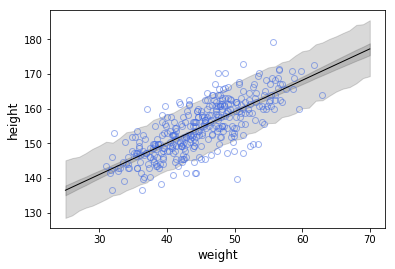

In [62]:
# plot raw data
plt.plot("weight", "height", "o", data=d2, c="royalblue", alpha=0.5, fillstyle="none")
plt.xlabel("weight")
plt.ylabel("height")

# draw MAP line
plt.plot(weight_seq.tolist(), mu_mean.tolist(), "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.15)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15);

#### Code 4.62

In [63]:
sim_height = m4_3.sim(weight=weight_seq, n=int(1e4))
height_PI = PI(sim_height, prob=0.89, dim=0)

#### Code 4.63

In [64]:
def sim(weight):
    mean = post["a"].unsqueeze(1) + post["b"].unsqueeze(1) * weight
    sd = post["sigma"].unsqueeze(1)
    return dist.Normal(loc=mean, scale=sd).sample()

post = m4_3.extract_samples()
weight_seq = torch.arange(start=25., end=71, step=1)
sim_height = sim(weight_seq)
height_PI = PI(sim_height, prob=0.89, dim=0)

#### Code 4.64

In [65]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d_weight = torch.tensor(d["weight"].values, dtype=torch.float)
d_height = torch.tensor(d["height"].values, dtype=torch.float)
print(d.info())
print(d.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB
None
    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0


#### Code 4.65

In [66]:
d_weight_s = (d_weight - d_weight.mean()) / d_weight.std()

#### Code 4.66

In [67]:
def m4_5_model(weight, weight2, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    mu = a + b1 * weight + b2 * weight2
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

d_weight_s2 = d_weight_s ** 2
m4_5 = MAP("m4.5", m4_5_model, weight=d_weight_s, weight2=d_weight_s2, height=d_height)
m4_5.fit(lr=0.2);

#### Code 4.67

In [68]:
m4_5.precis()

,Mean,StdDev,5.5%,94.5%
a,146.66,0.37,146.07,147.26
b1,21.40,0.29,20.94,21.86
b2,-8.42,0.28,-8.86,-7.97
sigma,5.75,0.17,5.47,6.03


#### Code 4.68

In [69]:
weight_seq = torch.linspace(start=-2.2, end=2, steps=30)
pred_data = {"weight": weight_seq, "weight2": weight_seq ** 2}
mu = m4_5.link(**pred_data)
mu_mean = mu.mean(0)
mu_PI = PI(mu, prob=0.89, dim=0)
sim_height = m4_5.sim(**pred_data)
height_PI = PI(sim_height, prob=0.89, dim=0)

#### Code 4.69

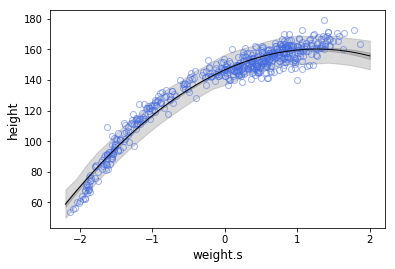

In [70]:
plt.plot(d_weight_s.tolist(), d_height.tolist(), "o",
         c="royalblue", alpha=0.5, fillstyle="none")
plt.xlabel("weight.s")
plt.ylabel("height")
plt.plot(weight_seq.tolist(), mu_mean.tolist(), "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.15)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15);

#### Code 4.70

In [71]:
def m4_6_model(weight, weight2, weight3, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    b3 = pyro.sample("b3", dist.Normal(0, 10))
    mu = a + b1 * weight + b2 * weight2 + b3 * weight3
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

d_weight_s3 = d_weight_s ** 3
m4_6 = MAP("m4.6", m4_6_model, weight=d_weight_s,
           weight2=d_weight_s2, weight3=d_weight_s3, height=d_height)
m4_6.fit(lr=0.2);

#### Code 4.71

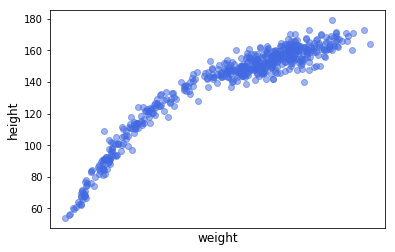

In [72]:
fig, ax = plt.subplots()
ax.plot(d_weight_s.tolist(), d_height.tolist(), "o", c="royalblue", alpha=0.5)
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.set_xticks([]);

#### Code 4.72

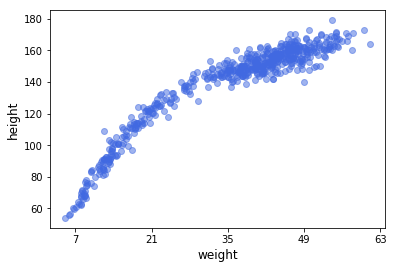

In [73]:
at = torch.tensor([-2, -1, 0, 1, 2])
labels = at * d_weight.std() + d_weight.mean()
ax.set_xticks(at.tolist())
ax.set_xticklabels([round(label.item(), 1) for label in labels])
fig

#### Code 4.73

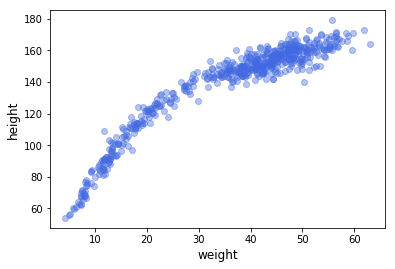

In [74]:
plt.plot("weight", "height", "o", data=howell1, c="royalblue", alpha=0.4)
plt.xlabel("weight")
plt.ylabel("height");